# **Intermediate Language Choice in Chat-related Tasks Project**

In [ ]:
%%capture

!pip install fasttext
!pip install -U easynmt
!pip install sacremoses
!pip install pandarallel
!pip install npm
!pip install nodeenv
!pip install -q Naked==0.1.31
!npm install --save @iamtraction/google-translate
!npm install -g npm
!pip install utils
!pip install transformers

In [ ]:
import ast
import io
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
import requests
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid, train_test_split
import string
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from transformers import (BertTokenizer, BertModel, DataCollatorWithPadding,
                          MT5Model, MT5ForConditionalGeneration, MT5Tokenizer,
                          XLMRobertaModel)
import uuid
from urllib.error import HTTPError
from typing import Union, List, Optional
from tqdm import tqdm
import fasttext
from gensim.parsing.preprocessing import STOPWORDS, remove_stopwords
from google.colab import drive
from Naked.toolshed.shell import muterun_js
import fasttext.util
from easynmt import EasyNMT
from pandarallel import pandarallel
from transformers import BloomModel, BloomTokenizerFast, AutoTokenizer, AutoModel

In [ ]:
pandarallel.initialize()
pd.options.display.max_colwidth = 1000
drive.mount('/content/drive/', force_remount=True) 

In [ ]:
def clean_text(text):
    """Clean up text from punctuation marks, numbers and other symbols."""
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text) 
    text = re.sub('\[|\]', '', text)
    text = re.sub('\(|\)', '', text)
    text = re.sub(r'\w*\d+\w*', '', text)
    text = re.sub('\s{2,}', " ", text)
    return text
    
def print_results(sample_size, precision, recall):
    """Print scores of a model: precision and recall."""
    precision = round(precision, 2)
    recall = round(recall, 2)
    print(f'sample_size = {sample_size}')
    print(f'precision = {precision}')
    print(f'recall = {recall}')

def parse_json(data):
    """Process JSON files and put them in a DataFrame."""
    parsed_dict = {}

    for column in data['turns']:
      global df

      NB, PB, B = 0, 0, 0
      parsed_dict['turn_index'] = column['turn-index']
      parsed_dict['speaker'] = column['speaker']
      parsed_dict['annonation_id'] = column['annotation-id']
      parsed_dict['utterance'] = column['utterance']
      
      for annotation in column['annotations']:
        if annotation != []:
          if annotation['breakdown'] == 'O':
              NB += 1
          elif annotation['breakdown'] == 'T':
              PB += 1
          elif annotation['breakdown'] == 'X':
              B += 1
              
      parsed_dict['NB'] = NB
      parsed_dict['PB'] = PB
      parsed_dict['B'] = B
      
      if (NB + PB +B) > 0:
        parsed_dict['prob_NB'] = NB * 1.0 / (NB + PB + B)
        parsed_dict['prob_PB'] = PB * 1.0 / (NB + PB + B)
        parsed_dict['prob_B'] = B * 1.0 / (NB + PB + B)
      else:
        parsed_dict['prob_NB'], parsed_dict['prob_PB'], parsed_dict['prob_B'] = 10, 10, 10

      df = df.append(parsed_dict, ignore_index=True, sort=False)

def base_english_dataset(sample):
    """Get development and evaluation datasets."""
    global df
    os.chdir(f'/content/drive/My Drive/DBDC_data/{sample} raw data/')    
    df = pd.DataFrame(columns=['turn_index', 'speaker', 'annonation_id', 'utterance', 'NB', 'PB', 'B', 'prob_NB', 'prob_PB', 'prob_B'])
    df_to_split = pd.DataFrame(columns=['utterance', 'label', 'utterance_A', 'utterance_B'])

    for file in os.listdir(os.curdir):
      if file.endswith('.log.json'):
        with open(file, 'r') as file_to_parse:
          data = json.load(file_to_parse)
          parse_json(data)

    df['utterance'] = df['utterance'].apply(clean_text)
    df['prob_NB'] = pd.to_numeric(df['prob_NB'])
    df['prob_PB'] = pd.to_numeric(df['prob_PB'])
    df['prob_B'] = pd.to_numeric(df['prob_B'])
    df['label'] = df[['prob_B', 'prob_PB', 'prob_NB']].idxmax(axis=1)

    for i in range(len(df.index)-1):    
      parsed_dict = {}
      
      parsed_dict['utterance_A'] = df.iloc[i]['utterance']
      parsed_dict['utterance_B'] = df.iloc[i+1]['utterance']
      parsed_dict['utterance'] = df.iloc[i]['utterance'] + ' ' + df.iloc[i+1]['utterance']
      parsed_dict['label'] = df.iloc[i+1]['label']

      if parsed_dict['utterance_A'] in df_to_split['utterance_B'].values:
        continue
      else:
        df_to_split = df_to_split.append(parsed_dict, ignore_index=True, sort=False)

    df_to_split = df_to_split.drop(['utterance_A', 'utterance_B'], axis=1)
    df_to_split.rename({'utterance': 'translation_en'}, axis=1, inplace=True)
    df_to_split = df_to_split.drop_duplicates(keep='last')
    df_to_split.to_csv(f'/content/drive/My Drive/DBDC_data/translation_files/DBDC_{sample}_translated_original_file_en.csv', index=False)

def get_official_google_translate(
    text: str,
    source_lang: Enum,
    target_lang: Enum
) -> str:
    """Get translation using Google Translate."""
    home_path = Path().resolve()
    translations_folder = str(Path(home_path, "translation_files"))
    if not os.path.exists(translations_folder):
      os.makedirs(translations_folder, exist_ok=True)
    file_translation = str(Path(translations_folder, f"{uuid.uuid4().hex}.js"))
    text = text.replace('\n', ' ').replace('\'', '\"')

    template = f"""const translate = require('@iamtraction/google-translate');
    translate(
        '{text}',
        {{from: '{source_lang}', to: '{target_lang}' }}).then(res => {{
    console.log(res.text); }}).catch(err => {{
    console.error(err);
    }});
    """
    with open(file_translation, "w", encoding="utf-8") as f:
        f.write(template)
    response = muterun_js(file_translation)

    os.remove(file_translation)
    return response.stdout.decode("utf-8")[:-1] 

def EasyNMT_translation(language, sample):
    """Get translation using EasyNMT."""

    os.chdir('/content/drive/My Drive/DBDC_data/translation_files/')

    model = EasyNMT('opus-mt')
    df_translated = pd.DataFrame(columns=['utterance', 'label', f'translation_{language}'])
    df_to_split = pd.read_csv(f'/content/drive/My Drive/DBDC_data/translation_files/DBDC_{sample}_translated_original_file_en.csv')

    for i in range(len(df_to_split.index)-1):
      parsed_dict = {}
      try:
        parsed_dict['utterance'] = df_to_split.iloc[i]['translation_en']
        parsed_dict['label'] = df_to_split.iloc[i]['label']
        parsed_dict[f'translation_{language}'] = model.translate(parsed_dict['utterance'], target_lang=language)

        df_translated = df_translated.append(parsed_dict, ignore_index=True, sort=False)
      except OSError:
        pass

    df_translated = df_translated.drop(['utterance'], axis=1)
    df_translated.to_csv(f'/content/drive/My Drive/DBDC_data/translation_files/DBDC_{sample}_translated_EasyNMT_file_{language}.csv', index=False)
    print('Translation of the language', language, 'is ready.')

def get_Google_translation(language, sample):
    """Get translation using Google translate."""
    df_to_split = pd.read_csv(f'/content/drive/My Drive/DBDC_data/translation_files/DBDC_{sample}_translated_original_file_en.csv')

    try:      
      df_to_split[f'translation_{language}'] = df_to_split.parallel_apply(lambda row: get_official_google_translate(row['translation_en'], 'en', language), axis=1)
      globals()[f'df_{sample}_translated_google_{language}'] = df_to_split.copy()
    except OSError:
      pass

    globals()[f'df_{sample}_translated_google_{language}'] = globals()[f'df_{sample}_translated_google_{language}'].drop(['translation_en'], axis=1)
    globals()[f'df_{sample}_translated_google_{language}'].to_csv(f'DBDC_{sample}_translated_Google_file_{language}.csv', index=False)

def train_models(language, translation_type):
    """Train a fastText model and print scores."""
    os.chdir(f'/content/drive/My Drive/DBDC_data/translation_files/')

    df_train = pd.read_csv(f'DBDC_dev_translated_{translation_type}_file_{language}.csv')
    df_train[f'translation_{language}'] = df_train[f'translation_{language}'].astype(str)
    df_train[f'translation_{language}'] = df_train[f'translation_{language}'].apply(clean_text)

    df_test = pd.read_csv(f'DBDC_eval_translated_{translation_type}_file_{language}.csv')
    df_test[f'translation_{language}'] = df_test[f'translation_{language}'].astype(str)
    df_test[f'translation_{language}'] = df_test[f'translation_{language}'].apply(clean_text)

    with open(f'train_{translation_type}_{language}.txt', 'w') as f:
        for each_text, each_label in zip(df_train[f'translation_{language}'], df_train['label']):
            f.writelines(f'__label__{each_label} {each_text}\n')
            
    with open(f'test_{translation_type}_{language}.txt', 'w') as f:
        for each_text, each_label in zip(df_test[f'translation_{language}'], df_test['label']):
            f.writelines(f'__label__{each_label} {each_text}\n')

    model = fasttext.train_supervised(f'train_{translation_type}_{language}.txt')
    
    print('Language: ', language, '\n', 'Translation type: ', translation_type, sep='')
    print_results(*model.test(f'test_{translation_type}_{language}.txt'))
    print('\n')

def load_vectors(file_name):
    """Load downloaded fastText vectors."""
    fin = io.open(file_name, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(list(map(float, tokens[1:])))
    return data

def create_dataset(csv_path, model_path, language):
    model = fasttext.load_model(model_path)
    df = pd.read_csv(csv_path)
    X = np.array([model.get_sentence_vector(sentence) for sentence in df[f'translation_{language}']]) #
    y = np.array(df['label'])
    return X, y
    
def preprocess(text):
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    vec = fasttext_model.get_sentence_vector(text)
    return vec

class TextDataset(Dataset):
    def __init__(self, df, language):
        self.texts = df[f'translation_{language}'] #
        self.labels = df['label']
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return preprocess(text), label
        
class FastTextClassifier(nn.Module):
    """Define the model architecture."""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        x = self.fc1(text)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x       

def evaluate(model, iterator):
    """Evaluate the model."""
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, label = batch
            predictions = model(text)
            loss = criterion(predictions, label)
            acc = (predictions.argmax(1) == label).float().mean()
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def accuracy(preds, y):
    """Define accuracy function."""
    rounded_preds = torch.argmax(preds, dim=1)
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion):
    """Train function."""
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:
        optimizer.zero_grad()

        text, label = batch
        predictions = model(text)
        loss = criterion(predictions, label)

        acc = accuracy(predictions, label)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# **fastText**

In [ ]:
df_scores_train = pd.DataFrame(columns=['Language', 'Translation type', 'Loss'])

languages_list = ['ru', 'af', 'de', 'it', 'es', 'en']
translation_types = ['EasyNMT', 'Google', 'original']

for language in languages_list:
  for translation_type in translation_types:
    try: 
      df = pd.read_csv(f'/content/drive/My Drive/DBDC_data/translation_files/DBDC_dev_translated_{translation_type}_file_{language}.csv')
      df['label'] = df['label'].replace({'prob_B': 0, 'prob_NB': 1, 'prob_PB': 2})

      fasttext_model_path = f'/content/drive/My Drive/DBDC_data/Models/cc.{language}.300.bin'
      fasttext_model = fasttext.load_model(fasttext_model_path)

      dataset = TextDataset(df, language)
      train_size = int(len(dataset) * 0.8)
      val_size = len(dataset) - train_size
      train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
      train_iterator = DataLoader(train_dataset, batch_size=32, shuffle=True)
      val_iterator = DataLoader(val_dataset, batch_size=32)

      n_epochs = 100
      learning_rate = 0.001
      input_dim = 300 
      hidden_dim = 50 
      output_dim = 3
      model = FastTextClassifier(input_dim, hidden_dim, output_dim)

      optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      criterion = nn.CrossEntropyLoss()

      train_losses = []
      train_accuracies = []
      for epoch in range(n_epochs):
          train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
          train_losses.append(train_loss)
          train_accuracies.append(train_acc)
      epochs = range(1, n_epochs+1)
      
      df_scores_train = df_scores_train.append(pd.Series([language, translation_type, train_losses[-1]], index=df_scores_train.columns), ignore_index=True)

      plt.plot(epochs, train_losses, label='Train Loss')

      plt.title(translation_type + ' ' + language)
      plt.xlabel('Epoch')
      plt.ylabel('Value')
      plt.legend()
      plt.show()

    except FileNotFoundError:
      pass

In [ ]:
# finding the best hyperparameters

hyperparameters = {
    'learning_rate': [0.001, 0.01, 0.1],
    'hidden_dim': [50, 100, 200],
    'batch_size': [16, 32, 64]
}

best_score = 0.0
best_params = {}

for params in ParameterGrid(hyperparameters):
    learning_rate = params['learning_rate']
    hidden_dim = params['hidden_dim']
    batch_size = params['batch_size']

    model = FastTextClassifier(input_dim, hidden_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    val_f1_scores = []
    for epoch in range(n_epochs):
        train(model, train_iterator, optimizer, criterion)

        val_pred = []
        val_true = []
        with torch.no_grad():
            for batch in val_iterator:
                text, label = batch
                text = text.squeeze()
                predictions = model(text)
                _, predicted_labels = torch.max(predictions, dim=1)
                val_pred.extend(predicted_labels.cpu().numpy().tolist())
                val_true.extend(label.cpu().numpy().tolist())

            val_f1_weighted = f1_score(val_true, val_pred, average='weighted')
            val_f1_scores.append(val_f1_weighted)

    if val_f1_scores[-1] > best_score:
        best_score = val_f1_scores[-1]
        best_params = params

print("Best Score:", best_score)
print("Best Parameters:", best_params)

Best Score: 0.5947443343593933
Best Parameters: {'batch_size': 16, 'hidden_dim': 100, 'learning_rate': 0.001}


In [ ]:
df_scores_test = pd.DataFrame(columns=['Language', 'Translation type', 'F1_weighted'])

languages_list = ['en', 'ru', 'af', 'de', 'it', 'es']
translation_types = ['EasyNMT', 'original', 'Google']

for language in languages_list:
    for translation_type in translation_types:
        try:
            df_train = pd.read_csv(f'/content/drive/My Drive/DBDC_data/translation_files/DBDC_dev_translated_{translation_type}_file_{language}.csv')
            df_train['label'] = df_train['label'].replace({'prob_B': 0, 'prob_NB': 1, 'prob_PB': 2})
            df_test = pd.read_csv(f'/content/drive/My Drive/DBDC_data/translation_files/DBDC_eval_translated_{translation_type}_file_{language}.csv')
            df_test['label'] = df_test['label'].replace({'prob_B': 0, 'prob_NB': 1, 'prob_PB': 2})

            df_train[f'translation_{language}'] = df_train[f'translation_{language}'].str.replace('\n', '')
            df_test[f'translation_{language}'] = df_test[f'translation_{language}'].str.replace('\n', '')

            train_dataset, val_dataset = TextDataset(df_train, language), TextDataset(df_test, language)
            train_size, val_size = len(train_dataset), len(val_dataset)

            train_iterator = DataLoader(train_dataset, batch_size=16, shuffle=True)
            val_iterator = DataLoader(val_dataset, batch_size=16)

            n_epochs = 100
            learning_rate = 0.001
            input_dim = 300 
            hidden_dim = 100
            output_dim = 3  
            model = FastTextClassifier(input_dim, hidden_dim, output_dim)

            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            criterion = nn.CrossEntropyLoss()

            val_f1_scores = []
            for epoch in range(n_epochs):
                train(model, train_iterator, optimizer, criterion)

                val_pred = []
                val_true = []
                with torch.no_grad():
                    for batch in val_iterator:
                        text, label = batch
                        text = text.squeeze()
                        predictions = model(text)
                        _, predicted_labels = torch.max(predictions, dim=1)
                        val_pred.extend(predicted_labels.cpu().numpy().tolist())
                        val_true.extend(label.cpu().numpy().tolist())

                val_f1_weighted = f1_score(val_true, val_pred, average='weighted')
                val_f1_scores.append(val_f1_weighted)

            df_scores_test = df_scores_test.append(pd.Series([language, translation_type, val_f1_scores[-1]], index=df_scores_test.columns), ignore_index=True)
            epochs = range(1, n_epochs+1)

            plt.plot(epochs, val_f1_scores, label='F1-weighted')

            plt.title(translation_type + ' ' + language)
            plt.xlabel('Epoch')
            plt.ylabel('Value')
            plt.legend()
            plt.show()
        except FileNotFoundError:
            pass

# **BERT**

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
labels = {'prob_B': 0,
          'prob_NB': 1,
          'prob_PB': 2
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df, language):
        self.labels = df['label'].map(labels)
        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df[f'translation_{language}']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 3)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

def evaluate(model, test_data, language):

    test = Dataset(test_data, language)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            predicted = output.argmax(dim=1)
            true_labels.extend(test_label.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    f1_weighted = f1_score(true_labels, predicted_labels, average='weighted')
    return f1_weighted

In [ ]:
df_scores_train_bert = pd.DataFrame(columns=['Language', 
                                             'Translation type', 
                                             'Train loss', 
                                             'Train Accuracy', 
                                             'Val Loss', 
                                             'Val Accuracy', 
                                             'Test f1_weighted'])

languages_list = ['ru', 'af', 'de', 'it', 'es', 'en']
translation_types = ['EasyNMT', 'Google', 'original']

for language in languages_list:
  for translation_type in translation_types:
    try: 
      df = pd.read_csv(f'/content/drive/My Drive/DBDC_data/translation_files/DBDC_dev_translated_{translation_type}_file_{language}.csv')
      test_data = pd.read_csv(f'/content/drive/My Drive/DBDC_data/translation_files/DBDC_dev_translated_{translation_type}_file_{language}.csv')
      
      dataset = Dataset(df, language)
      train_size = int(len(dataset) * 0.8)
      val_size = len(dataset) - train_size
      train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

      epochs = 5
      model = BertClassifier()
      lr = 0.000001

      train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)
      val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=2)

      use_cuda = torch.cuda.is_available()
      device = torch.device("cuda" if use_cuda else "cpu")

      criterion = nn.CrossEntropyLoss()
      optimizer = Adam(model.parameters(), lr=lr)

      if use_cuda:
          model = model.cuda()
          criterion = criterion.cuda()

      for epoch_num in range(epochs):
          total_acc_train = 0
          total_loss_train = 0
          
          for train_input, train_label in tqdm(train_dataloader):
              train_label = train_label.to(device)
              mask = train_input['attention_mask'].to(device)
              input_id = train_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              
              batch_loss = criterion(output, train_label.long())
              total_loss_train += batch_loss.item()
              
              acc = (output.argmax(dim=1) == train_label).sum().item()
              total_acc_train += acc

              model.zero_grad()
              batch_loss.backward()
              optimizer.step()
          
          total_acc_val = 0
          total_loss_val = 0

          with torch.no_grad():
              for val_input, val_label in val_dataloader:
                  val_label = val_label.to(device)
                  mask = val_input['attention_mask'].to(device)
                  input_id = val_input['input_ids'].squeeze(1).to(device)

                  output = model(input_id, mask)

                  batch_loss = criterion(output, val_label.long())
                  total_loss_val += batch_loss.item()
                  
                  acc = (output.argmax(dim=1) == val_label).sum().item()
                  total_acc_val += acc
          
          print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_dataset): .3f} | Train Accuracy: {total_acc_train / len(train_dataset): .3f} | Val Loss: {total_loss_val / len(val_dataset): .3f} | Val Accuracy: {total_acc_val / len(val_dataset): .3f}')
      
      f1_weighted = evaluate(model, test_data, language)
      df_scores_train_bert = df_scores_train_bert.append(pd.Series([language, 
                                                                    translation_type, 
                                                                    total_loss_train / len(train_dataset),
                                                                    total_acc_train / len(train_dataset),
                                                                    total_loss_val / len(val_dataset),
                                                                    total_acc_val / len(val_dataset),
                                                                    f1_weighted], index=df_scores_train_bert.columns), ignore_index=True)

    except FileNotFoundError:
      pass          

# **mT5 base**

In [ ]:
tokenizer = MT5Tokenizer.from_pretrained('google/mt5-base') 
labels = {'prob_B': 0,
          'prob_NB': 1,
          'prob_PB': 2
          }

class MT5Classifier(nn.Module):
    def __init__(self, num_classes):
        super(MT5Classifier, self).__init__()
        self.model = MT5ForConditionalGeneration.from_pretrained('google/mt5-base', return_dict=True)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, decoder_input_ids):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=decoder_input_ids)
        hidden_state = outputs.encoder_last_hidden_state[:, 0, :]
        hidden_state = self.dropout(hidden_state)
        logits = self.classifier(hidden_state)
        return logits


def preprocess_input(text):
    tokens = tokenizer.encode(text, padding=True, truncation=True, return_tensors='pt')

    input_ids = tokens.input_ids
    attention_mask = tokens.attention_mask

    return input_ids, attention_mask

class DatasetMT5(torch.utils.data.Dataset):
    def __init__(self, df, language, tokenizer):
        self.labels = df['label'].map(labels)
        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text, padding='max_length', max_length=512, truncation=True, return_tensors="pt") for text in df[f'translation_{language}']]
        self.decoder_inputs = [tokenizer(text, padding='max_length', max_length=512, truncation=True, return_tensors="pt") for text in df[f'translation_{language}']]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        batch_texts = self.texts[idx]
        batch_decoder_inputs = self.decoder_inputs[idx]
        batch_y = self.labels[idx]

        return {
            'input_ids': batch_texts['input_ids'].squeeze(0),
            'attention_mask': batch_texts['attention_mask'].squeeze(0),
            'decoder_input_ids': batch_decoder_inputs['input_ids'].squeeze(0)
        }, batch_y

def evaluate(model, test_data, language):
    test = DatasetMT5(test_data, language, tokenizer)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    model.eval()

    total_loss = 0
    total_predictions = []
    total_labels = []

    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_input = {key: value.to(device) for key, value in test_input.items()}
            test_label = test_label.to(device)
            input_ids = test_input['input_ids'].squeeze(1)
            decoder_input_ids = test_input['decoder_input_ids'].squeeze(1)
            attention_mask = test_input['attention_mask']

            output = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids, attention_mask=attention_mask)

            loss = criterion(output, test_label.long())
            total_loss += loss.item()

            predictions = torch.argmax(output, dim=1).cpu().numpy()
            labels = test_label.cpu().numpy()

            total_predictions.extend(predictions)
            total_labels.extend(labels)

    average_loss = total_loss / len(test_dataloader)
    f1_weighted = f1_score(total_labels, total_predictions, average='weighted')

    model.train()  

    return f1_weighted

In [ ]:
torch.cuda.empty_cache()
torch.backends.cuda.max_split_size_mb = 0.1

df_scores_train_mt5 = pd.DataFrame(columns=['Language', 'Translation type', 'Train loss', 'Train Accuracy', 'Val Loss', 'Val Accuracy', 'Test f1_weighted'])

languages_list = ['ru', 'af', 'de', 'it', 'es', 'en']
translation_types = ['EasyNMT', 'Google', 'original']

for language in languages_list:
  for translation_type in translation_types:
    try: 
      df = pd.read_csv(f'/content/drive/My Drive/DBDC_data/translation_files/DBDC_dev_translated_{translation_type}_file_{language}.csv')
      test_data = pd.read_csv(f'/content/drive/My Drive/DBDC_data/translation_files/DBDC_dev_translated_{translation_type}_file_{language}.csv')
      
      dataset = DatasetMT5(df, language, tokenizer)
      train_size = int(len(dataset) * 0.8)
      val_size = len(dataset) - train_size
      train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
      
      epochs = 5
      model = MT5Classifier(3)
      lr = 0.000001

      train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
      val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1)

      use_cuda = torch.cuda.is_available()
      device = torch.device("cuda" if use_cuda else "cpu")

      criterion = nn.CrossEntropyLoss()
      optimizer = Adam(model.parameters(), lr=lr)

      if use_cuda:
          model = model.cuda()
          criterion = criterion.cuda()

      for epoch_num in range(epochs):
          total_acc_train = 0
          total_loss_train = 0

          for batch_texts, batch_y in tqdm(train_dataloader):
              train_input_ids = batch_texts['input_ids'].to(device)
              train_decoder_input_ids = batch_texts['decoder_input_ids'].to(device)
              attention_mask = batch_texts['attention_mask'].to(device)

              output = model(input_ids=train_input_ids, attention_mask=attention_mask, decoder_input_ids=train_decoder_input_ids)          

          for train_input, train_label in tqdm(train_dataloader):
              train_label = train_label.to(device)
              mask = train_input['attention_mask'].to(device)
              input_ids = train_input['input_ids'].squeeze(1).to(device)
              decoder_input_ids = train_input['decoder_input_ids'].squeeze(1).to(device)

              output = model(input_ids=input_ids, attention_mask=mask, decoder_input_ids=decoder_input_ids)
              
              batch_loss = criterion(output, train_label.long())
              total_loss_train += batch_loss.item()
              
              acc = (output.argmax(dim=1) == train_label).sum().item()
              total_acc_train += acc

              model.zero_grad()
              batch_loss.backward()
              optimizer.step()

          total_acc_val = 0
          total_loss_val = 0

          with torch.no_grad():
              for val_input, val_label in val_dataloader:
                  val_label = val_label.to(device)
                  input_ids = val_input['input_ids'].squeeze(1).to(device)
                  decoder_input_ids = val_input['decoder_input_ids'].squeeze(1).to(device)
                  attention_mask = val_input['attention_mask'].to(device)

                  output = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids, attention_mask=attention_mask)

                  batch_loss = criterion(output, val_label.long())
                  total_loss_val += batch_loss.item()
                  
                  acc = (output.argmax(dim=1) == val_label).sum().item()
                  total_acc_val += acc
                    
          print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_dataset): .3f} | Train Accuracy: {total_acc_train / len(train_dataset): .3f} | Val Loss: {total_loss_val / len(val_dataset): .3f} | Val Accuracy: {total_acc_val / len(val_dataset): .3f}')
      
      f1_weighted = evaluate(model, test_data, language)
      df_scores_train_mt5 = df_scores_train_mt5.append(pd.Series([language, 
                                                                    translation_type, 
                                                                    total_loss_train / len(train_dataset),
                                                                    total_acc_train / len(train_dataset),
                                                                    total_loss_val / len(val_dataset),
                                                                    total_acc_val / len(val_dataset),
                                                                    f1_weighted], index=df_scores_train_mt5.columns), ignore_index=True)

    except FileNotFoundError:
      pass   

df_scores_train_mt5.to_csv('/content/drive/My Drive/DBDC_data/Stats/Scores_train_mt5_with_test.csv', index=False)       

# **mT5 large**

In [ ]:
tokenizer = MT5Tokenizer.from_pretrained('google/mt5-large') 
labels = {'prob_B': 0,
          'prob_NB': 1,
          'prob_PB': 2
          }

class MT5Classifier(nn.Module):
    def __init__(self, num_classes):
        super(MT5Classifier, self).__init__()
        self.model = MT5ForConditionalGeneration.from_pretrained('google/mt5-large', return_dict=True)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, decoder_input_ids):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=decoder_input_ids)
        hidden_state = outputs.encoder_last_hidden_state[:, 0, :]
        hidden_state = self.dropout(hidden_state)
        logits = self.classifier(hidden_state)
        return logits

def preprocess_input(text):
    tokens = tokenizer.encode(text, padding=True, truncation=True, return_tensors='pt')

    input_ids = tokens.input_ids
    attention_mask = tokens.attention_mask

    return input_ids, attention_mask

class DatasetMT5(torch.utils.data.Dataset):
    def __init__(self, df, language, tokenizer):
        self.labels = df['label'].map(labels)
        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text, padding='max_length', max_length=512, truncation=True, return_tensors="pt") for text in df[f'translation_{language}']]
        self.decoder_inputs = [tokenizer(text, padding='max_length', max_length=512, truncation=True, return_tensors="pt") for text in df[f'translation_{language}']]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        batch_texts = self.texts[idx]
        batch_decoder_inputs = self.decoder_inputs[idx]
        batch_y = self.labels[idx]

        return {
            'input_ids': batch_texts['input_ids'].squeeze(0),
            'attention_mask': batch_texts['attention_mask'].squeeze(0),
            'decoder_input_ids': batch_decoder_inputs['input_ids'].squeeze(0)
        }, batch_y

def evaluate(model, test_data, language):
    test = DatasetMT5(test_data, language, tokenizer)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    model.eval()

    total_loss = 0
    total_predictions = []
    total_labels = []

    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_input = {key: value.to(device) for key, value in test_input.items()}
            test_label = test_label.to(device)
            input_ids = test_input['input_ids'].squeeze(1)
            decoder_input_ids = test_input['decoder_input_ids'].squeeze(1)
            attention_mask = test_input['attention_mask']

            output = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids, attention_mask=attention_mask)

            loss = criterion(output, test_label.long())
            total_loss += loss.item()

            predictions = torch.argmax(output, dim=1).cpu().numpy()
            labels = test_label.cpu().numpy()

            total_predictions.extend(predictions)
            total_labels.extend(labels)

    average_loss = total_loss / len(test_dataloader)
    f1_weighted = f1_score(total_labels, total_predictions, average='weighted')

    model.train()  

    return f1_weighted

In [ ]:
torch.backends.cuda.max_split_size_mb = 0.1

translation_types = ['EasyNMT', 'Google', 'original']
languages_list = ['ru', 'af', 'de', 'it', 'es', 'en']

df_scores_train_mt5_large = pd.DataFrame(columns=['Language', 'Translation type', 'Train loss', 'Train Accuracy', 'Val Loss', 'Val Accuracy', 'Test f1_weighted'])
df_scores_train_mt5_large.to_csv('/content/drive/My Drive/DBDC_data/Stats/Scores_train_mt5_large_with_test.csv', index=False)

for language in languages_list:
  for translation_type in translation_types:
    try: 
      df_scores_train_mt5_large = pd.read_csv('/content/drive/My Drive/DBDC_data/Stats/Scores_train_mt5_large_with_test.csv')      
      df = pd.read_csv(f'/content/drive/My Drive/DBDC_data/translation_files/DBDC_dev_translated_{translation_type}_file_{language}.csv')
      test_data = pd.read_csv(f'/content/drive/My Drive/DBDC_data/translation_files/DBDC_dev_translated_{translation_type}_file_{language}.csv')
      
      dataset = DatasetMT5(df, language, tokenizer)
      train_size = int(len(dataset) * 0.8)
      val_size = len(dataset) - train_size
      train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
      
      epochs = 5
      model = MT5Classifier(3)
      lr = 0.000001

      use_cuda = torch.cuda.is_available()
      device = torch.device("cuda" if use_cuda else "cpu")

      criterion = nn.CrossEntropyLoss()
      optimizer = Adam(model.parameters(), lr=lr)

      if use_cuda:
          model = model.cuda()
          criterion = criterion.cuda()
      
      torch.cuda.empty_cache()
      
      train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
      val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1)

      for epoch_num in range(epochs):
          total_acc_train = 0
          total_loss_train = 0

          for batch_texts, batch_y in tqdm(train_dataloader):
              train_input_ids = batch_texts['input_ids'].to(device)
              train_decoder_input_ids = batch_texts['decoder_input_ids'].to(device)
              attention_mask = batch_texts['attention_mask'].to(device)

              output = model(input_ids=train_input_ids, attention_mask=attention_mask, decoder_input_ids=train_decoder_input_ids)          

          for train_input, train_label in tqdm(train_dataloader):
              train_label = train_label.to(device)
              mask = train_input['attention_mask'].to(device)
              input_ids = train_input['input_ids'].squeeze(1).to(device)
              decoder_input_ids = train_input['decoder_input_ids'].squeeze(1).to(device)

              output = model(input_ids=input_ids, attention_mask=mask, decoder_input_ids=decoder_input_ids)
              
              batch_loss = criterion(output, train_label.long())
              total_loss_train += batch_loss.item()
              
              acc = (output.argmax(dim=1) == train_label).sum().item()
              total_acc_train += acc

              model.zero_grad()
              batch_loss.backward()
              optimizer.step()

          total_acc_val = 0
          total_loss_val = 0

          with torch.no_grad():
              for val_input, val_label in val_dataloader:
                  val_label = val_label.to(device)
                  input_ids = val_input['input_ids'].squeeze(1).to(device)
                  decoder_input_ids = val_input['decoder_input_ids'].squeeze(1).to(device)
                  attention_mask = val_input['attention_mask'].to(device)

                  output = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids, attention_mask=attention_mask)

                  batch_loss = criterion(output, val_label.long())
                  total_loss_val += batch_loss.item()
                  
                  acc = (output.argmax(dim=1) == val_label).sum().item()
                  total_acc_val += acc
                    
          print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_dataset): .3f} | Train Accuracy: {total_acc_train / len(train_dataset): .3f} | Val Loss: {total_loss_val / len(val_dataset): .3f} | Val Accuracy: {total_acc_val / len(val_dataset): .3f}')
      
      f1_weighted = evaluate(model, test_data, language)
      print(f1_weighted)
      df_scores_train_mt5_large = df_scores_train_mt5_large.append(pd.Series([language, 
                                                                    translation_type, 
                                                                    total_loss_train / len(train_dataset),
                                                                    total_acc_train / len(train_dataset),
                                                                    total_loss_val / len(val_dataset),
                                                                    total_acc_val / len(val_dataset),
                                                                    f1_weighted], index=df_scores_train_mt5_large.columns), ignore_index=True)
      df_scores_train_mt5_large.to_csv('/content/drive/My Drive/DBDC_data/Stats/Scores_train_mt5_large_with_test.csv', index=False)
    except FileNotFoundError:
      pass

# **BLOOM**

In [ ]:
tokenizer = BloomTokenizerFast.from_pretrained('bigscience/bloom-560m')
labels = {'prob_B': 0, 'prob_NB': 1, 'prob_PB': 2}

class BLOOMClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BLOOMClassifier, self).__init__()
        self.model = BloomModel.from_pretrained('bigscience/bloom-560m', return_dict=True)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state[:, 0, :]
        hidden_state = self.dropout(hidden_state)
        logits = self.classifier(hidden_state)
        return logits

def preprocess_input(text):
    encoded_inputs = tokenizer.encode_plus(
        text,
        padding='max_length',
        max_length=512,
        truncation=True,
        return_tensors='pt'
    )
    input_ids = encoded_inputs['input_ids']
    attention_mask = encoded_inputs['attention_mask']
    return {
        'input_ids': input_ids.squeeze(0),
        'attention_mask': attention_mask.squeeze(0),
    }


class DatasetBLOOM(torch.utils.data.Dataset):
    def __init__(self, df, language, tokenizer):
        self.labels = [labels[label] for label in df['label']]
        self.texts = [
            tokenizer(
                text,
                padding='max_length',
                max_length=512,
                truncation=True,
                return_tensors="pt",
                add_special_tokens=False,
                return_attention_mask=True,
                return_token_type_ids=False,
            ) for text in df[f'translation_{language}']
        ]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        batch_texts = self.texts[idx]
        batch_y = self.labels[idx]

        return {
            'input_ids': batch_texts['input_ids'].squeeze(0),
            'attention_mask': batch_texts['attention_mask'].squeeze(0),
        }, batch_y

        
def collate_fn(batch):
    if isinstance(batch[0], tuple):
        batch_texts = [item[0]['input_ids'] for item in batch]
        batch_y = [item[1] for item in batch]
    else:
        batch_texts = [item['input_ids'] for item in batch]
        batch_y = None

    max_length = max(text.size(0) for text in batch_texts)
    batch_texts = [torch.cat([text, torch.zeros(max_length - text.size(0), dtype=torch.long)]) for text in batch_texts]
    batch_texts = torch.stack(batch_texts)

    if batch_y is not None:
        batch_y = torch.tensor(batch_y)

    return {'input_ids': batch_texts, 'attention_mask': batch_texts != 0}, batch_y


def evaluate(model, test_data, language):
    test = DatasetBLOOM(test_data, language, tokenizer)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    model.eval()

    total_loss = 0
    total_predictions = []
    total_labels = []
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_input = {key: value.to(device) for key, value in test_input.items()}
            test_label = test_label.to(device)
            input_ids = test_input['input_ids'].squeeze(1)
            attention_mask = test_input['attention_mask']

            output = model(input_ids=input_ids, attention_mask=attention_mask)

            loss = criterion(output, test_label.long())
            total_loss += loss.item()

            predictions = torch.argmax(output, dim=1).cpu().numpy()
            labels = test_label.cpu().numpy()

            total_predictions.extend(predictions)
            total_labels.extend(labels)

    average_loss = total_loss / len(test_dataloader)
    f1_weighted = f1_score(total_labels, total_predictions, average='weighted')

    model.train()

    return f1_weighted

In [ ]:
torch.cuda.empty_cache()
torch.backends.cuda.max_split_size_mb = 0.1
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

languages_list = ['ru', 'af', 'de', 'it', 'es', 'en']
translation_types = ['EasyNMT', 'Google', 'original']
df_scores_train_bloom = pd.DataFrame(columns=['Language', 'Translation type', 'Train loss', 'Train Accuracy', 'Val Loss', 'Val Accuracy', 'Test f1_weighted'])
df_scores_train_bloom.to_csv('/content/drive/My Drive/DBDC_data/Stats/Scores_train_bloom_with_test.csv', index=False)

for language in languages_list:
    for translation_type in translation_types:
        try:
            df_scores_train_bloom = pd.read_csv('/content/drive/My Drive/DBDC_data/Stats/Scores_train_bloom_with_test.csv')
            df = pd.read_csv(f'/content/drive/My Drive/DBDC_data/translation_files/DBDC_dev_translated_{translation_type}_file_{language}.csv')
            test_data = pd.read_csv(f'/content/drive/My Drive/DBDC_data/translation_files/DBDC_dev_translated_{translation_type}_file_{language}.csv')

            dataset = DatasetBLOOM(df, language, tokenizer)
            train_size = int(len(dataset) * 0.8)
            val_size = len(dataset) - train_size
            train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

            epochs = 5
            model = BLOOMClassifier(3)
            lr = 0.000001

            train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, collate_fn=collate_fn, shuffle=True)
            val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, collate_fn=collate_fn, shuffle=True)

            use_cuda = torch.cuda.is_available()
            device = torch.device("cuda" if use_cuda else "cpu")

            criterion = nn.CrossEntropyLoss()
            optimizer = Adam(model.parameters(), lr=lr)

            if use_cuda:
                model = model.cuda()
                criterion = criterion.cuda()

            for epoch_num in range(epochs):
                total_acc_train = 0
                total_loss_train = 0

                for batch_texts, batch_y in tqdm(train_dataloader):
                    batch_texts = {key: value.to(device) for key, value in batch_texts.items()}
                    batch_y = batch_y.to(device)

                    output = model(**batch_texts)

                    batch_loss = criterion(output, batch_y)
                    total_loss_train += batch_loss.item()

                    acc = (output.argmax(dim=1) == batch_y).sum().item()
                    total_acc_train += acc

                    model.zero_grad()
                    batch_loss.backward()
                    optimizer.step()

                total_acc_val = 0
                total_loss_val = 0

                with torch.no_grad():
                    for val_input, val_label in val_dataloader:
                        val_label = val_label.to(device)
                        input_ids = val_input['input_ids'].squeeze(1).to(device)
                        attention_mask = val_input['attention_mask'].to(device)

                        output = model(input_ids=input_ids, attention_mask=attention_mask)

                        batch_loss = criterion(output, val_label.long())
                        total_loss_val += batch_loss.item()

                        acc = (output.argmax(dim=1) == val_label).sum().item()
                        total_acc_val += acc

                print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_dataset): .3f} | Train Accuracy: {total_acc_train / len(train_dataset): .3f} | Val Loss: {total_loss_val / len(val_dataset): .3f} | Val Accuracy: {total_acc_val / len(val_dataset): .3f}')

            f1_weighted = evaluate(model, test_data, language)
            df_scores_train_bloom = df_scores_train_bloom.append(pd.Series([language,
                                                                              translation_type,
                                                                              total_loss_train / len(train_dataset),
                                                                              total_acc_train / len(train_dataset),
                                                                              total_loss_val / len(val_dataset),
                                                                              total_acc_val / len(val_dataset),
                                                                              f1_weighted], index=df_scores_train_bloom.columns), ignore_index=True)

            df_scores_train_bloom.to_csv('/content/drive/My Drive/DBDC_data/Stats/Scores_train_bloom_with_test.csv', index=False)
        except FileNotFoundError:
            pass


# **XLMR**



In [ ]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
model = AutoModel.from_pretrained('xlm-roberta-base')

labels = {'prob_B': 0, 'prob_NB': 1, 'prob_PB': 2}

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, language):
        self.labels = [labels[label] for label in df['label']]
        self.texts = [
            tokenizer(
                text,
                padding='max_length',
                max_length=512,
                truncation=True,
                return_tensors="pt"
            )
            for text in df[f'translation_{language}']
        ]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

class BertClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = XLMRobertaModel.from_pretrained('xlm-roberta-base')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids.squeeze(1),
            attention_mask=attention_mask.squeeze(1),
            return_dict=True
        )
        pooled_output = outputs.pooler_output
        dropout_output = self.dropout(pooled_output)
        logits = self.classifier(dropout_output)
        return logits

def evaluate(model, test_data, language):
    test = Dataset(test_data, language)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        model = model.cuda()
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_ids = test_input['input_ids'].to(device)
            output = model(input_ids, mask)
            predicted = output.argmax(dim=1)
            true_labels.extend(test_label.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    f1_weighted = f1_score(true_labels, predicted_labels, average='weighted')
    return f1_weighted


languages_list = ['ru', 'af', 'de', 'it', 'es', 'en']
translation_types = ['EasyNMT', 'Google', 'original']

df_scores_train_xlmr = pd.DataFrame(columns=['Language', 'Translation type', 'Train loss', 'Train Accuracy', 'Val Loss', 'Val Accuracy', 'Test f1_weighted'])
df_scores_train_xlmr.to_csv('/content/drive/My Drive/DBDC_data/Stats/Scores_train_xlmr_with_test.csv', index=False)

for language in languages_list:
    for translation_type in translation_types:
        try:
            df_scores_train_xlmr = pd.read_csv('/content/drive/My Drive/DBDC_data/Stats/Scores_train_xlmr_with_test.csv')      
            df = pd.read_csv(f'/content/drive/My Drive/DBDC_data/translation_files/DBDC_dev_translated_{translation_type}_file_{language}.csv')
            test_data = pd.read_csv(f'/content/drive/My Drive/DBDC_data/translation_files/DBDC_dev_translated_{translation_type}_file_{language}.csv')

            dataset = Dataset(df, language)
            train_size = int(len(dataset) * 0.8)
            val_size = len(dataset) - train_size
            train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

            epochs = 5
            lr = 0.000001

            model = BertClassifier(num_classes=3)
            train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
            val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1)

            use_cuda = torch.cuda.is_available()
            device = torch.device("cuda" if use_cuda else "cpu")

            criterion = nn.CrossEntropyLoss()
            optimizer = Adam(model.parameters(), lr=lr)

            if use_cuda:
                model = model.cuda()
                criterion = criterion.cuda()

            for epoch_num in range(epochs):
                total_acc_train = 0
                total_loss_train = 0

                for train_input, train_label in tqdm(train_dataloader):
                    train_label = train_label.to(device)
                    mask = train_input['attention_mask'].to(device)
                    input_id = train_input['input_ids'].to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, train_label.long())
                    total_loss_train += batch_loss.item()
                    acc = (output.argmax(dim=1) == train_label).sum().item()
                    total_acc_train += acc
                    model.zero_grad()
                    batch_loss.backward()
                    optimizer.step()


                total_acc_val = 0
                total_loss_val = 0

                with torch.no_grad():
                    for val_input, val_label in val_dataloader:
                        val_label = val_label.to(device)
                        val_input = {key: val_input[key][0] for key in val_input} 
                        mask = val_input['attention_mask'].to(device)
                        input_ids = val_input['input_ids'].squeeze(1).to(device)
                        output = model(input_ids, mask)


                        batch_loss = criterion(output, val_label.long())
                        total_loss_val += batch_loss.item()

                        acc = (output.argmax(dim=1) == val_label).sum().item()
                        total_acc_val += acc

                print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_dataset): .3f} | Train Accuracy: {total_acc_train / len(train_dataset): .3f} | Val Loss: {total_loss_val / len(val_dataset): .3f} | Val Accuracy: {total_acc_val / len(val_dataset): .3f}')

            f1_weighted = evaluate(model, test_data, language)
            df_scores_train_xlmr = df_scores_train_xlmr.append(pd.Series([language,
                                                                          translation_type,
                                                                          total_loss_train / len(train_dataset),
                                                                          total_acc_train / len(train_dataset),
                                                                          total_loss_val / len(val_dataset),
                                                                          total_acc_val / len(val_dataset),
                                                                          f1_weighted], index=df_scores_train_xlmr.columns), ignore_index=True)
            df_scores_train_xlmr.to_csv('/content/drive/My Drive/DBDC_data/Stats/Scores_train_xlmr_with_test.csv', index=False)
        except FileNotFoundError:
            pass

# **Results**

In [14]:
df_fasttext = pd.read_csv('/content/drive/My Drive/DBDC_data/Stats/Scores_train_fasttext_with_test.csv')      
df_bert = pd.read_csv('/content/drive/My Drive/DBDC_data/Stats/Scores_train_bert_with_test.csv')      
df_mt5_base = pd.read_csv('/content/drive/My Drive/DBDC_data/Stats/Scores_train_mt5_with_test.csv')      
df_mt5_large = pd.read_csv('/content/drive/My Drive/DBDC_data/Stats/Scores_train_mt5_large_with_test.csv')      
df_bloom = pd.read_csv('/content/drive/My Drive/DBDC_data/Stats/Scores_train_bloom_with_test.csv')  
df_xlmr = pd.read_csv('/content/drive/My Drive/DBDC_data/Stats/Scores_train_xlmr_with_test.csv')  

In [15]:
df_fasttext

,Language,Translation type,Val Loss,Test f1_weighted
0,ru,EasyNMT,0.561546,0.562101
1,ru,Google,0.542576,0.566561
2,af,EasyNMT,0.522780,0.575810
3,af,Google,0.510189,0.561931
4,de,EasyNMT,0.599812,0.563081
5,de,Google,0.613612,0.548491
6,it,EasyNMT,0.532135,0.577868
7,it,Google,0.556205,0.559060
8,es,EasyNMT,0.526301,0.562038
9,es,Google,0.602590,0.578552


In [16]:
df_bert

,Language,Translation type,Train loss,Train Accuracy,Val Loss,Val Accuracy,Test f1_weighted
0,ru,EasyNMT,0.387952,0.706938,0.420508,0.681818,0.583120
1,ru,Google,0.363987,0.721496,0.378036,0.718009,0.649499
2,af,EasyNMT,0.374263,0.698925,0.369215,0.725537,0.602816
3,af,Google,0.342770,0.723278,0.434525,0.665877,0.663784
4,de,EasyNMT,0.356944,0.737470,0.362511,0.730310,0.702133
5,de,Google,0.347894,0.754157,0.382704,0.739336,0.690238
6,it,EasyNMT,0.360816,0.725806,0.396272,0.701671,0.629538
7,it,Google,0.347594,0.701900,0.405945,0.720379,0.591512
8,es,EasyNMT,0.349335,0.730907,0.396392,0.666667,0.693017
9,es,Google,0.375021,0.717340,0.383621,0.722749,0.651938


In [17]:
df_mt5_base 

,Language,Translation type,Train loss,Train Accuracy,Val Loss,Val Accuracy,Test f1_weighted
0,ru,EasyNMT,0.783124,0.625598,0.793674,0.638756,0.568323
1,ru,Google,0.920470,0.478029,0.964307,0.457346,0.476461
2,af,EasyNMT,0.771956,0.637993,0.895773,0.603819,0.566815
3,af,Google,0.894826,0.587886,0.926017,0.601896,0.579708
4,de,EasyNMT,0.760460,0.647971,0.852001,0.596659,0.564994
5,de,Google,0.793298,0.634204,0.815665,0.635071,0.578046
6,it,EasyNMT,0.772355,0.693548,0.877616,0.656325,0.581883
7,it,Google,0.846343,0.697150,0.829094,0.708531,0.579708
8,es,EasyNMT,0.753481,0.698091,0.821203,0.719048,0.580582
9,es,Google,0.782378,0.703682,0.867164,0.665877,0.584594


In [18]:
df_mt5_large

,Language,Translation type,Train loss,Train Accuracy,Val Loss,Val Accuracy,Test f1_weighted
0,ru,EasyNMT,0.710777,0.696770,0.798248,0.708134,0.591857
1,ru,Google,0.781587,0.656770,0.760176,0.706161,0.584404
2,af,EasyNMT,0.769268,0.672640,0.819039,0.696897,0.585484
3,af,Google,0.789612,0.671615,0.862804,0.630332,0.589658
4,de,EasyNMT,0.774669,0.689737,0.818972,0.713604,0.578587
5,de,Google,0.761400,0.675772,0.824510,0.651659,0.591146
6,it,EasyNMT,0.774632,0.692354,0.786798,0.737470,0.578909
7,it,Google,0.806131,0.694181,0.802143,0.713270,0.578832
8,es,EasyNMT,0.741942,0.694511,0.757917,0.735714,0.582008
9,es,Google,0.768646,0.702494,0.830128,0.699052,0.578832


In [19]:
df_bloom

,Language,Translation type,Train loss,Train Accuracy,Val Loss,Val Accuracy,Test f1_weighted
0,ru,EasyNMT,0.999300,0.629187,1.129562,0.349282,0.238124
1,ru,Google,1.025679,0.622328,0.949721,0.661137,0.577910
2,af,EasyNMT,0.991424,0.630824,0.929922,0.601432,0.578909
3,af,Google,1.028676,0.632423,0.934693,0.699052,0.578832
4,de,EasyNMT,1.021684,0.625298,1.039038,0.668258,0.579051
5,de,Google,1.013370,0.625297,0.931862,0.668246,0.578832
6,it,EasyNMT,1.008939,0.629032,1.058595,0.482100,0.578909
7,it,Google,1.043350,0.617577,0.977524,0.720379,0.578832
8,es,EasyNMT,1.028065,0.624105,1.085621,0.409524,0.481176
9,es,Google,1.035631,0.615796,0.890465,0.706161,0.578832


In [20]:
df_xlmr

,Language,Translation type,Train loss,Train Accuracy,Val Loss,Val Accuracy,Test f1_weighted
0,ru,EasyNMT,0.648476,0.721292,0.857701,0.665072,0.651340
1,ru,Google,0.495573,0.764252,0.892478,0.689573,0.738242
2,af,EasyNMT,0.646514,0.699522,0.812533,0.718377,0.593762
3,af,Google,0.550864,0.812352,0.806428,0.696682,0.767123
4,de,EasyNMT,0.594822,0.715394,0.787677,0.715990,0.649060
5,de,Google,0.586915,0.716746,0.810917,0.682464,0.640312
6,it,EasyNMT,0.520488,0.732975,0.775041,0.718377,0.668997
7,it,Google,0.522446,0.728029,0.897454,0.691943,0.676348
8,es,EasyNMT,0.549347,0.704057,0.792341,0.721429,0.612263
9,es,Google,0.493426,0.789786,0.845921,0.703791,0.774161


In [21]:
df_total = pd.DataFrame(columns=['Model', 'Language', 'Translation type', 'Train loss', 'Train Accuracy', 'Val Loss', 'Val Accuracy', 'Test f1_weighted'])
df_total = pd.concat([df_total, df_bloom], ignore_index=True)
df_total.fillna('BLOOM', inplace=True)
df_total = pd.concat([df_total, df_mt5_large], ignore_index=True)
df_total.fillna('MT5-Large', inplace=True)
df_total = pd.concat([df_total, df_mt5_base], ignore_index=True)
df_total.fillna('MT5-Base', inplace=True)
df_total = pd.concat([df_total, df_bert], ignore_index=True)
df_total.fillna('BERT', inplace=True)
df_total = pd.concat([df_total, df_xlmr], ignore_index=True)
df_total.fillna('XLM-R', inplace=True)
df_total = pd.concat([df_total, df_fasttext], ignore_index=True)
df_total['Model'].fillna('fastText', inplace=True)
df_total.fillna(0, inplace=True)
df_total.drop(columns=['Train loss', 'Train Accuracy', 'Val Accuracy'], inplace=True)

language_mapping = {
    'ru': 'Russian',
    'af': 'Afrikaans',
    'de': 'German',
    'it': 'Italian',
    'es': 'Spanish',
    'en': 'English'
}

df_total['Language'] = df_total['Language'].replace(language_mapping)
df_total['Translation type'] = df_total['Translation type'].replace('original', 'Original')

df_total

,Model,Language,Translation type,Val Loss,Test f1_weighted
0,BLOOM,Russian,EasyNMT,1.129562,0.238124
1,BLOOM,Russian,Google,0.949721,0.577910
2,BLOOM,Afrikaans,EasyNMT,0.929922,0.578909
3,BLOOM,Afrikaans,Google,0.934693,0.578832
4,BLOOM,German,EasyNMT,1.039038,0.579051
...,...,...,...,...,...
61,fastText,Italian,EasyNMT,0.532135,0.577868
62,fastText,Italian,Google,0.556205,0.559060
63,fastText,Spanish,EasyNMT,0.526301,0.562038
64,fastText,Spanish,Google,0.602590,0.578552


In [23]:
df_translation_types_mean = df_total.groupby(['Translation type'])['Test f1_weighted'].mean().reset_index()
df_translation_types_mean

,Translation type,Test f1_weighted
0,EasyNMT,0.582085
1,Google,0.609079
2,Original,0.639991


In [25]:
df_languages_mean = df_total.groupby(['Language', 'Translation type'])['Test f1_weighted'].mean().reset_index()
df_languages_mean

,Language,Translation type,Test f1_weighted
0,Afrikaans,EasyNMT,0.583933
1,Afrikaans,Google,0.623506
2,English,Original,0.639991
3,German,EasyNMT,0.606151
4,German,Google,0.604511
5,Italian,EasyNMT,0.602684
6,Italian,Google,0.594049
7,Russian,EasyNMT,0.532478
8,Russian,Google,0.598846
9,Spanish,EasyNMT,0.585181


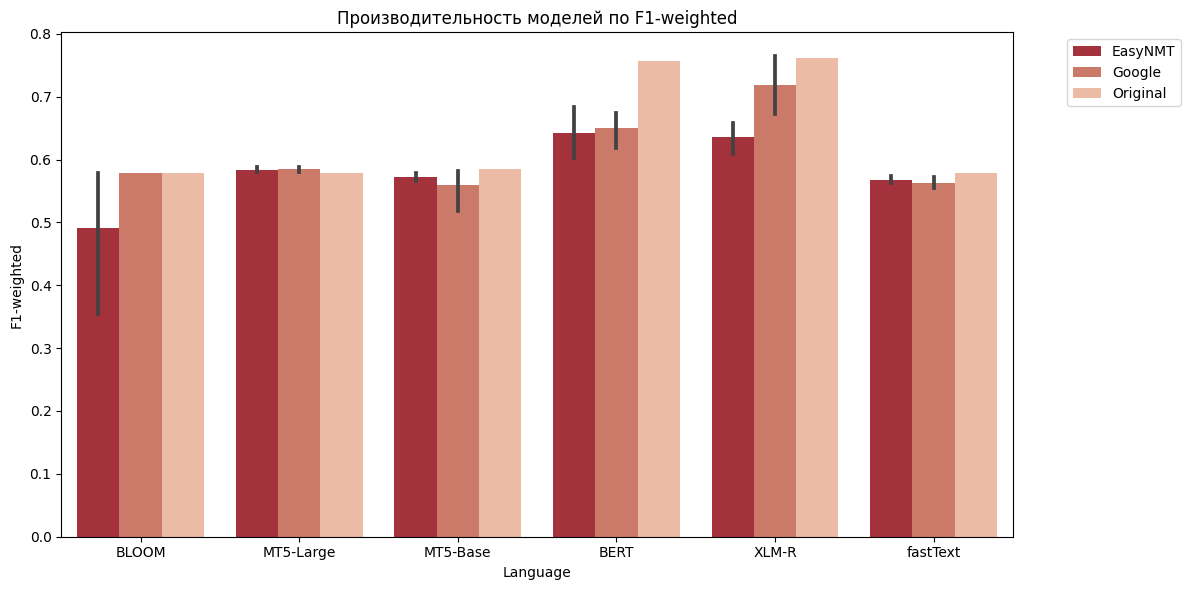

In [ ]:
df_language = df_total.copy()
plt.figure(figsize=(12, 6))
sns.barplot(data=df_language, x='Model', y='Test f1_weighted', hue='Translation type', palette=sns.color_palette("RdBu", 8))

plt.xlabel('Language')
plt.ylabel('F1-weighted')
plt.title('Производительность моделей по F1-weighted')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [39]:
df_models_mean = df_total.groupby(['Model', 'Translation type'])['Test f1_weighted'].mean().reset_index()
df_models_mean.pivot(index='Translation type', columns='Model', values='Test f1_weighted')

Model,BERT,BLOOM,MT5-Base,MT5-Large,XLM-R,fastText
Translation type,,,,,,
EasyNMT,0.642125,0.491234,0.572520,0.583369,0.635084,0.568180
Google,0.649394,0.578648,0.559703,0.584575,0.719237,0.562919
Original,0.757161,0.578832,0.585417,0.578832,0.760987,0.578717


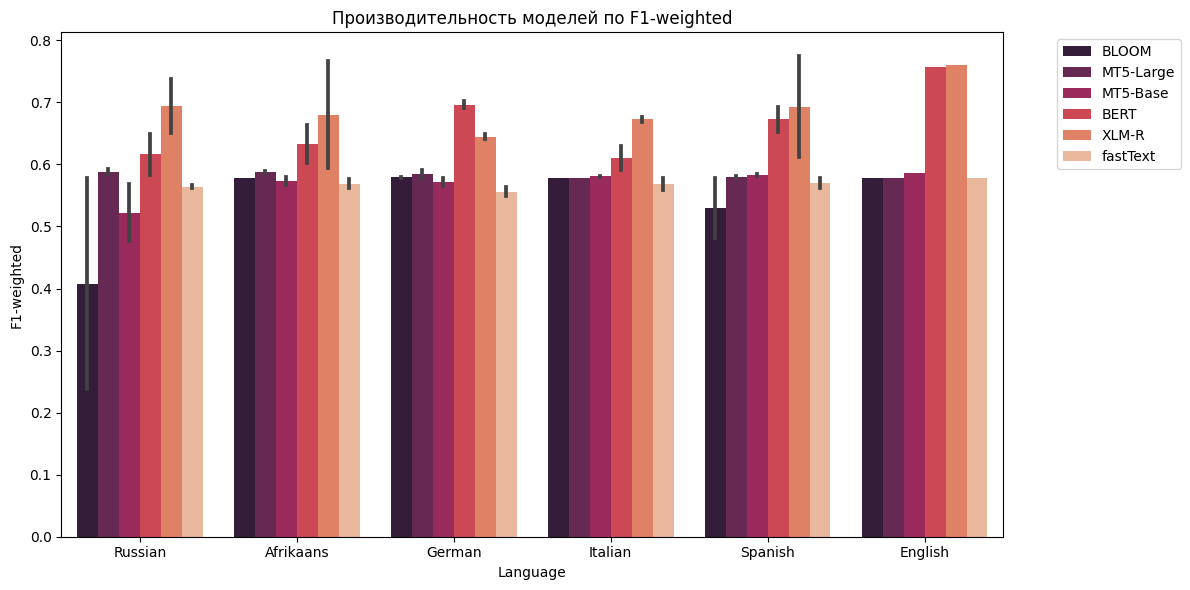

In [ ]:
df_language = df_total.copy()
plt.figure(figsize=(12, 6))
sns.barplot(data=df_language, x='Language', y='Test f1_weighted', hue='Model', palette=sns.color_palette('rocket'))

plt.xlabel('Language')
plt.ylabel('F1-weighted')
plt.title('Производительность моделей по F1-weighted')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

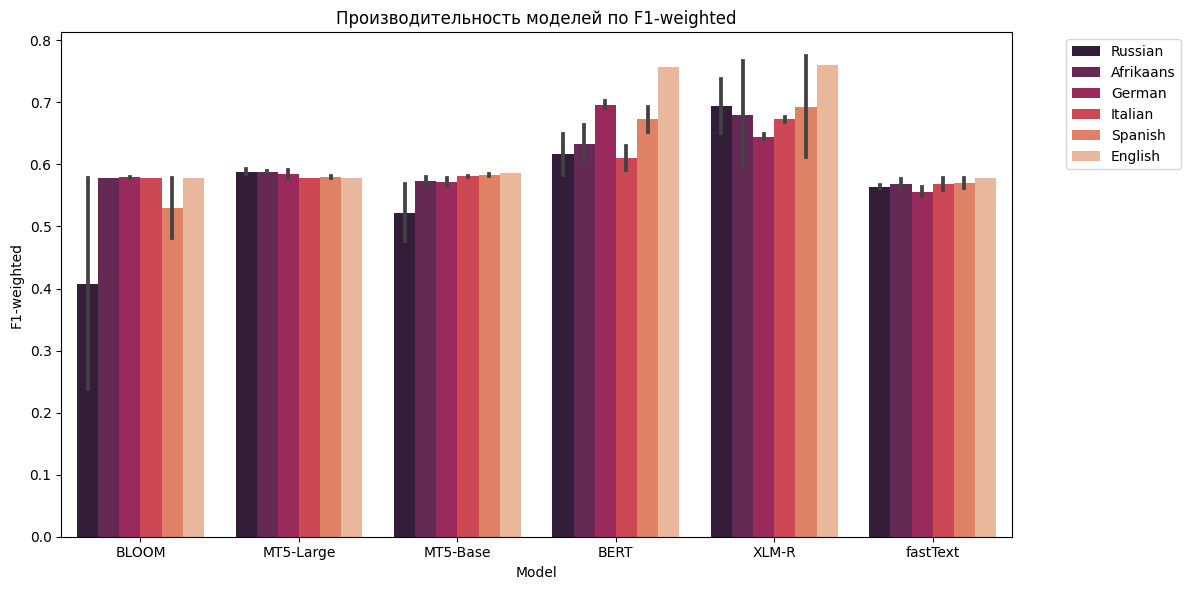

In [ ]:
df_language = df_total.copy()
plt.figure(figsize=(12, 6))
sns.barplot(data=df_language, x='Model', y='Test f1_weighted', hue='Language', palette=sns.color_palette('rocket'))

plt.xlabel('Model')
plt.ylabel('F1-weighted')
plt.title('Производительность моделей по F1-weighted')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [40]:
df_models_and_languages = df_total.groupby(['Model', 'Language'])['Test f1_weighted'].mean().reset_index().pivot(index='Language', columns='Model', values='Test f1_weighted').reset_index()
df_models_and_languages

Model,Language,BERT,BLOOM,MT5-Base,MT5-Large,XLM-R,fastText
0,Afrikaans,0.633300,0.578871,0.573262,0.587571,0.680442,0.568871
1,English,0.757161,0.578832,0.585417,0.578832,0.760987,0.578717
2,German,0.696186,0.578941,0.571520,0.584867,0.644686,0.555786
3,Italian,0.610525,0.578871,0.580796,0.578871,0.672672,0.568464
4,Russian,0.616309,0.408017,0.522392,0.588131,0.694791,0.564331
5,Spanish,0.672477,0.530004,0.582588,0.580420,0.693212,0.570295


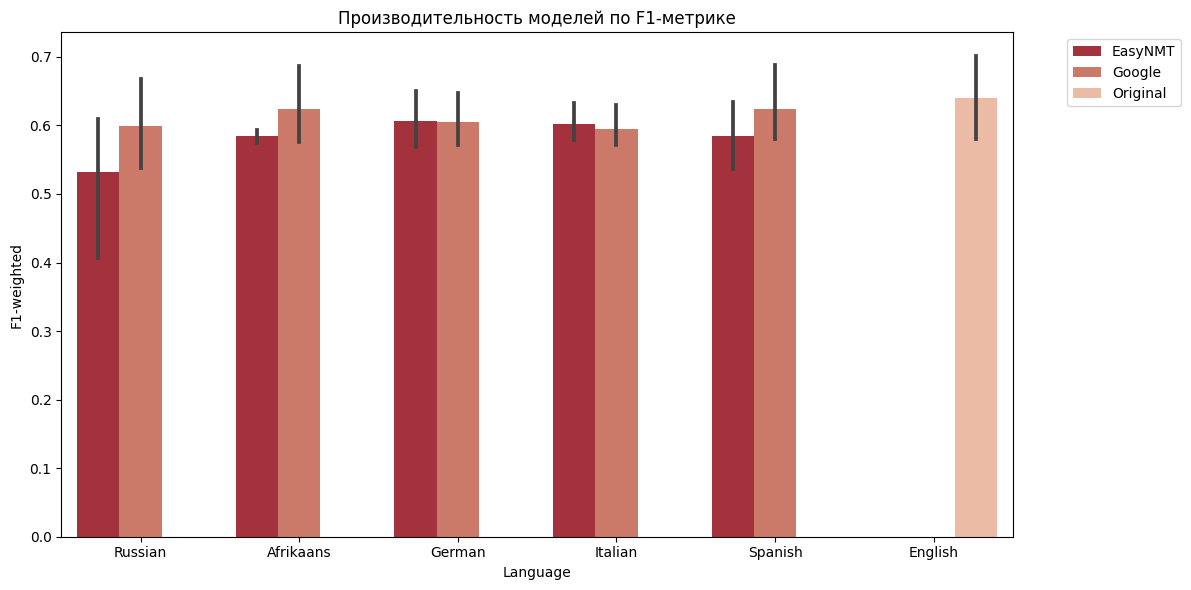

In [ ]:
df_language = df_total.copy()
plt.figure(figsize=(12, 6))
sns.barplot(data=df_language, x='Language', y='Test f1_weighted', hue='Translation type', palette=sns.color_palette("RdBu", 8))

plt.xlabel('Language')
plt.ylabel('F1-weighted')
plt.title('Производительность моделей по F1-метрике')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

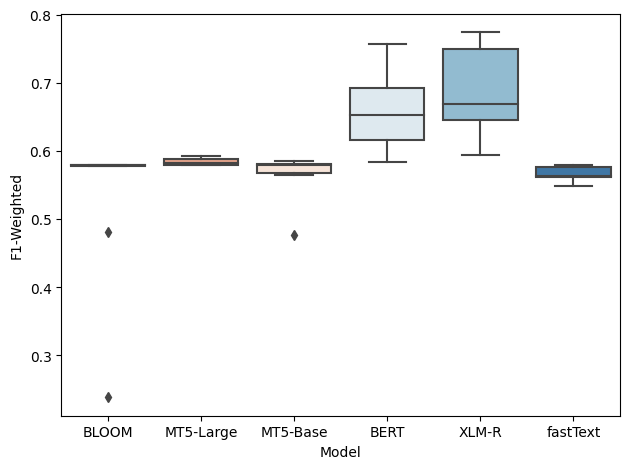

In [47]:
df_language = df_total.copy()

sns.boxplot(data=df_language, x='Model', y='Test f1_weighted', palette=sns.color_palette("RdBu", 6))

plt.xlabel('Model')
plt.ylabel('F1-Weighted')

plt.tight_layout()
plt.show()


Google Translate Method

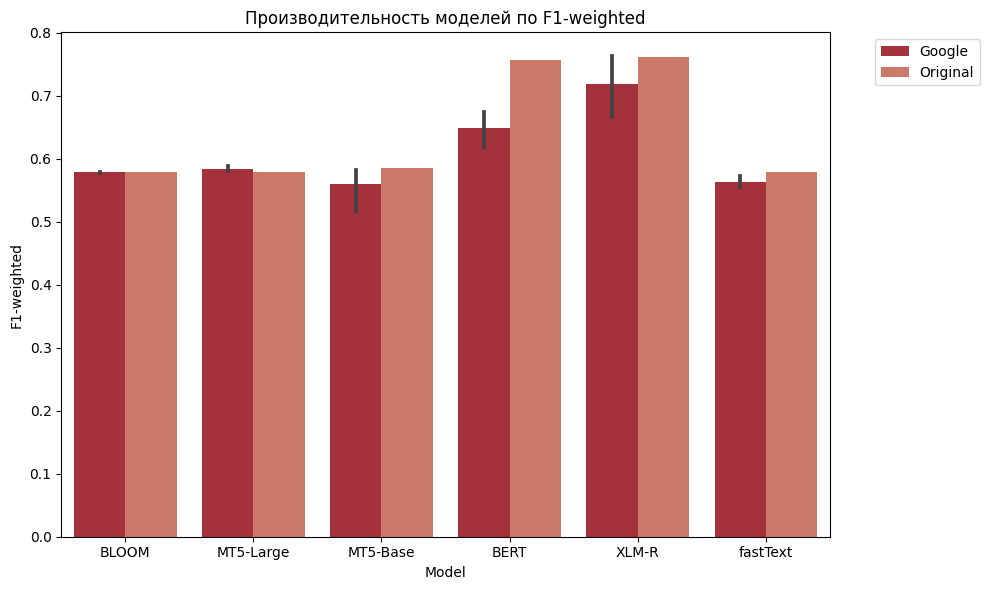

In [54]:
df_language = df_total[(df_total['Translation type'] == 'Google') | (df_total['Translation type'] == 'Original')]
plt.figure(figsize=(10, 6))
sns.barplot(data=df_language, x='Model', y='Test f1_weighted', hue='Translation type', palette=sns.color_palette("RdBu", 8))

plt.xlabel('Model')
plt.ylabel('F1-weighted')
plt.title('Производительность моделей по F1-weighted')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

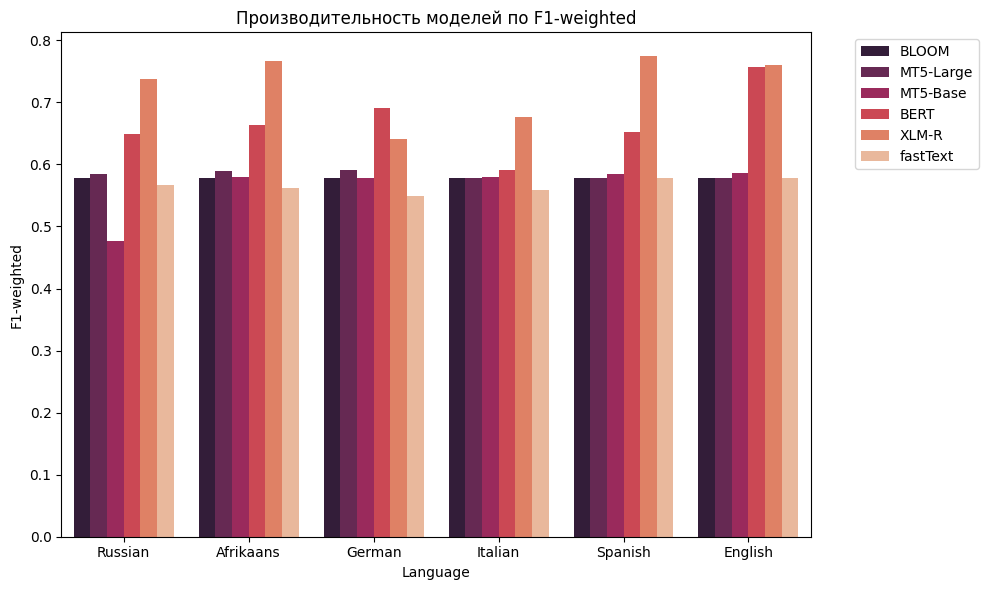

In [55]:
df_language = df_total[(df_total['Translation type'] == 'Google') | (df_total['Translation type'] == 'Original')]
plt.figure(figsize=(10, 6))
sns.barplot(data=df_language, x='Language', y='Test f1_weighted', hue='Model', palette=sns.color_palette('rocket'))

plt.xlabel('Language')
plt.ylabel('F1-weighted')
plt.title('Производительность моделей по F1-weighted')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

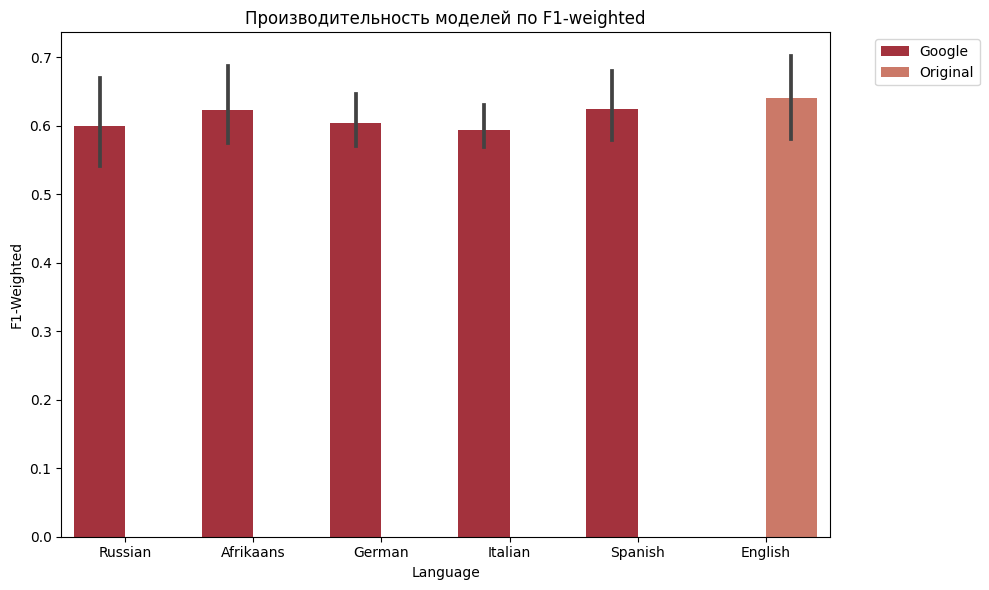

In [56]:
df_language = df_total[(df_total['Translation type'] == 'Google') | (df_total['Translation type'] == 'Original')]

plt.figure(figsize=(10, 6))
sns.barplot(data=df_language, x='Language', y='Test f1_weighted', hue='Translation type', palette=sns.color_palette("RdBu", 8))

plt.xlabel('Language')
plt.ylabel('F1-Weighted')
plt.title('Производительность моделей по F1-weighted')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

EasyNMT Method

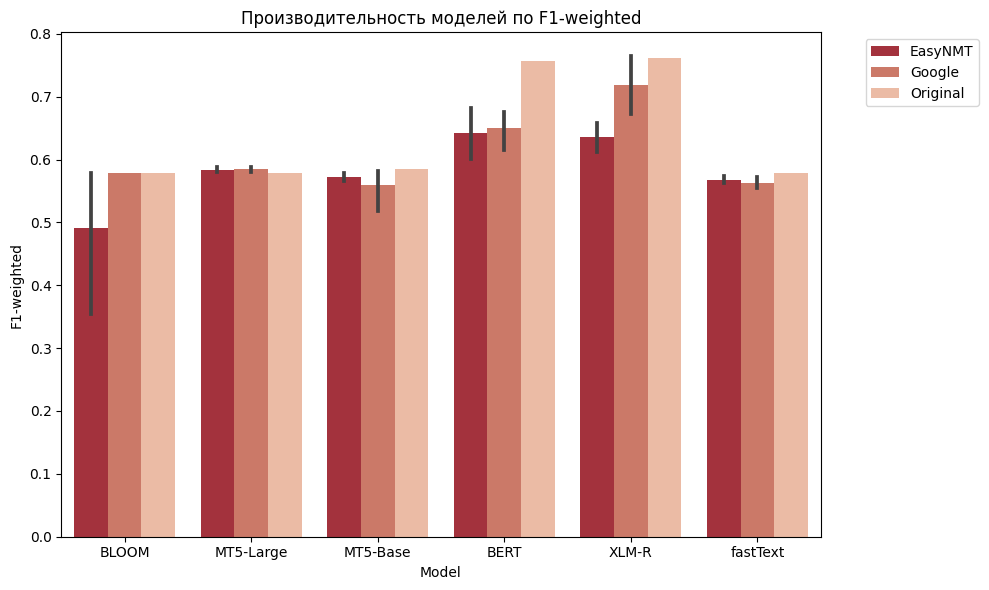

In [57]:
df_language = df_total.copy()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_language, x='Model', y='Test f1_weighted', hue='Translation type', palette=sns.color_palette("RdBu", 8))

plt.xlabel('Model')
plt.ylabel('F1-weighted')
plt.title('Производительность моделей по F1-weighted')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

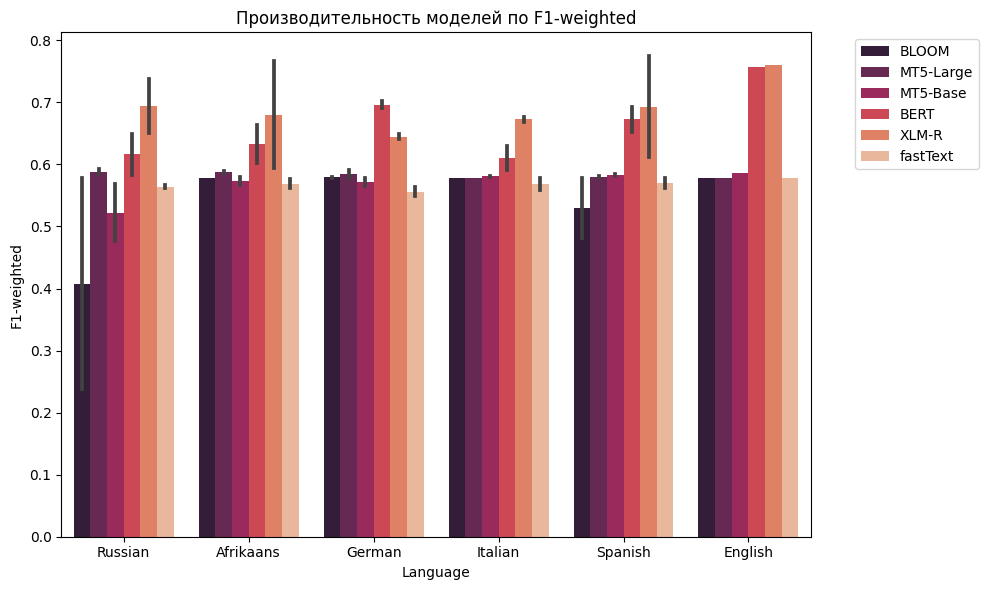

In [58]:
df_language = df_total.copy()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_language, x='Language', y='Test f1_weighted', hue='Model', palette=sns.color_palette('rocket'))

plt.xlabel('Language')
plt.ylabel('F1-weighted')
plt.title('Производительность моделей по F1-weighted')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

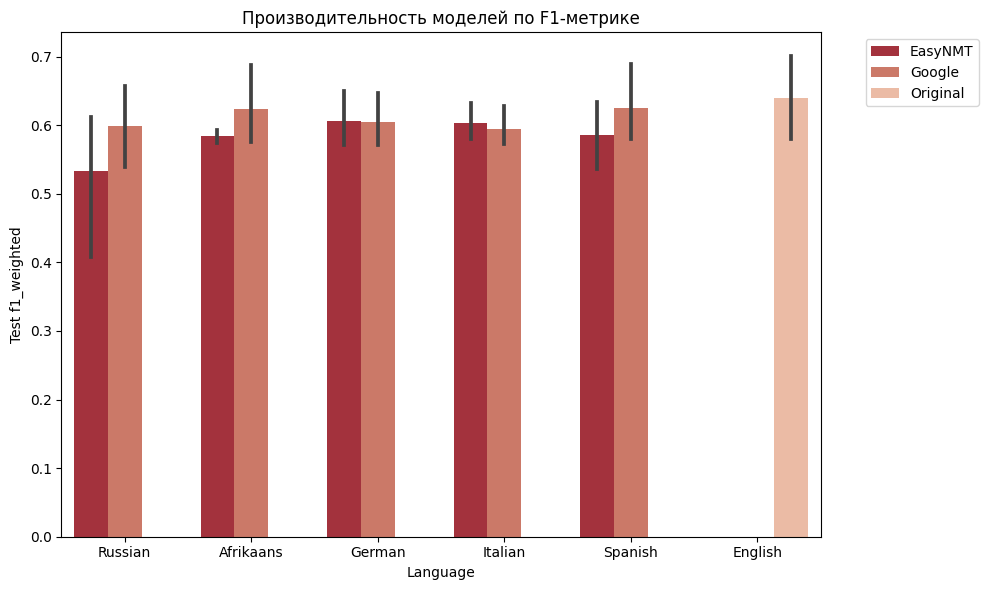

In [59]:
df_language = df_total.copy()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_language, x='Language', y='Test f1_weighted', hue='Translation type', palette=sns.color_palette("RdBu", 8))

plt.xlabel('Language')
plt.ylabel('Test f1_weighted')
plt.title('Производительность моделей по F1-метрике')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()